In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
import numpy as np 
from operators.FOM import charge_density_two_stream
from operators.setup_ROM_two_stream import SimulationSetupTwoStreamROM
from operators.FOM import total_mass, total_momentum, total_energy_k, psi_ln_aw
import scipy
from operators.poisson_solver import linear_solver_v2, gmres_solver

In [4]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

plt.rcParams['figure.figsize'] = (5,3)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
#plt.rcParams["animation.html"] = "html5" # for matplotlib 2.0 and below, converts to x264 using ffmpeg video codec

# Two Stream Instability ROM

In [5]:
setup = SimulationSetupTwoStreamROM(Nx=251,
                                    Nv=350,
                                    epsilon=0.1,
                                    alpha_e1=0.5,
                                    alpha_e2=0.5,
                                    alpha_i=np.sqrt(2 / 1836),
                                    u_e1=-1.065,
                                    u_e2=1.065,
                                    u_i=0,
                                    L=2 * np.pi,
                                    dt=1e-2,
                                    T0=0,
                                    T=30,
                                    nu_e1=15,
                                    nu_e2=15,
                                    n0_e1=0.5,
                                    n0_e2=0.5,
                                    Nr=150,
                                    M=3,
                                    problem_dir="two_stream",
                                    Ur_e1=np.load("../data/ROM/two_stream/basis_SVD_e1_0_30_M_3.npy"),
                                    Ur_e2=np.load("../data/ROM/two_stream/basis_SVD_e2_0_30_M_3.npy"),
                                    construct=False)

In [6]:
# ions (unperturbed + static)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [7]:
# velocity grid for plotting purposes
v = np.linspace(-2.5, 2.5, int(1e3), endpoint=True)
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx + 1, endpoint=True)

## simulation dataset

In [8]:
skip = 10

# load the simulation results
sol_u_reduced = np.load("../data/ROM/two_stream/sample_" + str(setup.u_e2) + "/M" + str(setup.M) + "/sol_ROM_u_" + str(setup.Nr) + "_nu_" + str(setup.nu_e1) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[:, ::skip]
sol_midpoint_t = np.load("../data/ROM/two_stream/sample_" + str(setup.u_e2) + "/M" + str(setup.M) + "/sol_ROM_t_" + str(setup.Nr) + "_nu_" + str(setup.nu_e1) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[::skip]
setup.dt = setup.dt * skip

# print simulation dimensions
print(np.shape(sol_u_reduced))
print(np.shape(sol_midpoint_t))

(1806, 301)
(301,)


In [9]:
runtime =  np.load("../data/ROM/two_stream/sample_" + str(setup.u_e2)  + "/M" + str(setup.M) + "/sol_ROM_u_" + str(setup.Nr) + "_nu_" + str(setup.nu_e1) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([2533.394404 ,  364.6216011])

In [10]:
sol_midpoint_u = np.zeros((2*setup.Nx*setup.Nv, len(sol_midpoint_t)))
# e1
sol_midpoint_u[:setup.NF, :] = sol_u_reduced[:setup.NF, :]
sol_midpoint_u[setup.NF:setup.Nx*setup.Nv, :] = setup.Ur_e1 @ sol_u_reduced[setup.NF:setup.Nr+setup.NF, :]
# e2
sol_midpoint_u[setup.Nx*setup.Nv:setup.Nx*setup.Nv +setup.NF, :] = sol_u_reduced[setup.NF + setup.Nr: 2*setup.NF + setup.Nr, :]
sol_midpoint_u[setup.Nx*setup.Nv +setup.NF:, :] = setup.Ur_e2 @ sol_u_reduced[2*setup.NF + setup.Nr:, :]

In [11]:
# initialize the states for implicit midpoint (symplectic)
state_e1_midpoint = np.zeros((setup.Nv, setup.Nx + 1, len(sol_midpoint_t)))
state_e2_midpoint = np.zeros((setup.Nv, setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t), 1):
    print("time = ", sol_midpoint_t[ii])
    # unwind the flattening to solve the Vlasov-Poisson system
    # electrons
    state_e1_midpoint[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv*setup.Nx, ii], (setup.Nv, setup.Nx)) 
    state_e1_midpoint[:, -1, ii] = state_e1_midpoint[:, 0, ii]

    state_e2_midpoint[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv*setup.Nx:, ii], (setup.Nv, setup.Nx)) 
    state_e2_midpoint[:, -1, ii] = state_e2_midpoint[:, 0, ii]

    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_two_stream(alpha_e1=setup.alpha_e1,alpha_e2=setup.alpha_e2, alpha_i=setup.alpha_i,
                                        q_e1=setup.q_e1, q_e2=setup.q_e2, q_i=setup.q_i,
                                        C0_e1=state_e1_midpoint[0, :-1, ii],
                                        C0_e2=state_e2_midpoint[0, :-1, ii],
                                        C0_i=C0_ions)
    
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, atol=1e-12, rtol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

time =  0.0
time =  0.1
time =  0.2
time =  0.3
time =  0.4
time =  0.5
time =  0.6
time =  0.7000000000000001
time =  0.8
time =  0.9
time =  1.0
time =  1.1
time =  1.2
time =  1.3
time =  1.4000000000000001
time =  1.5
time =  1.6
time =  1.7
time =  1.8
time =  1.9000000000000001
time =  2.0
time =  2.1
time =  2.2
time =  2.3000000000000003
time =  2.4
time =  2.5
time =  2.6
time =  2.7
time =  2.8000000000000003
time =  2.9
time =  3.0
time =  3.1
time =  3.2
time =  3.3000000000000003
time =  3.4
time =  3.5
time =  3.6
time =  3.7
time =  3.8000000000000003
time =  3.9
time =  4.0
time =  4.1
time =  4.2
time =  4.3
time =  4.4
time =  4.5
time =  4.6000000000000005
time =  4.7
time =  4.8
time =  4.9
time =  5.0
time =  5.1000000000000005
time =  5.2
time =  5.3
time =  5.4
time =  5.5
time =  5.6000000000000005
time =  5.7
time =  5.8
time =  5.9
time =  6.0
time =  6.1000000000000005
time =  6.2
time =  6.3
time =  6.4
time =  6.5
time =  6.6000000000000005
time =  6.7
time

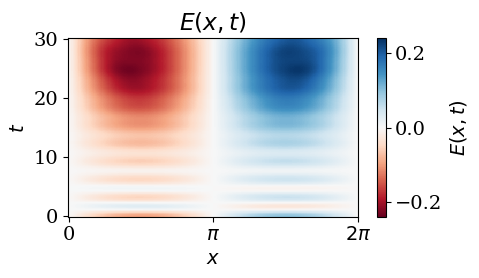

In [12]:
# plot the electric field
fig, ax = plt.subplots(figsize=(5, 3))
pos = ax.pcolormesh(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu",vmin=-0.24, vmax=0.24)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

#plt.savefig("../figs/ROM/two_stream/electric_field_ROM_" + str(setup.u_e2)+ ".png", dpi=600)

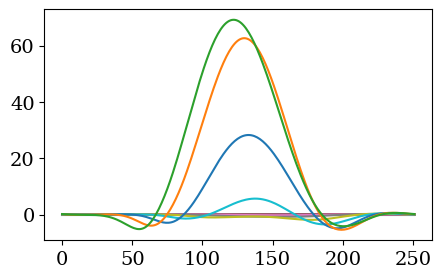

In [13]:
_ = plt.plot(state_e2_midpoint[10, :, ::25])

In [14]:
state_e1_FOM = np.load("../data/FOM/two_stream/sample_" + str(setup.u_e2) + "/state_e1_midpoint.npy")
state_e2_FOM = np.load("../data/FOM/two_stream/sample_" + str(setup.u_e2) + "/state_e2_midpoint.npy")

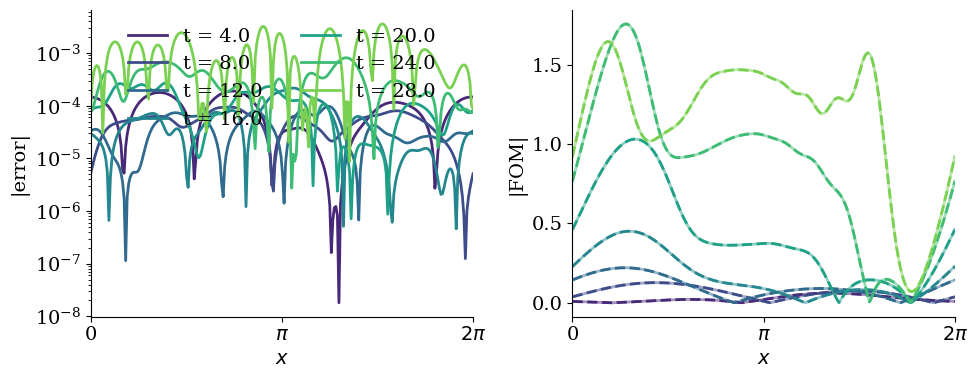

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
moment = 2
skip = 40
# Choose a colormap
cmap = plt.get_cmap('viridis')
# Get an array of colors from the colormap
colors = cmap(np.linspace(0, 0.8, int(len(sol_midpoint_t)//skip + 1))) 

for ii in np.arange(1, int(len(sol_midpoint_t)//skip + 1)):
    _ = ax[0].plot(x, np.abs(state_e1_midpoint[moment, :, ii*skip] - state_e1_FOM[moment, :, ii*skip]), c=colors[ii], linewidth=2, label="t = " + str(sol_midpoint_t[skip*ii]))
    _ = ax[1].plot(x, np.abs(state_e1_FOM[moment, :, ii*skip]), c=colors[ii], linewidth=2, alpha=0.5)
    _ = ax[1].plot(x, np.abs(state_e1_midpoint[moment, :, ii*skip]), color=colors[ii], ls="--", linewidth=2)
ax[0].set_yscale("log")
#ax[1].set_yscale("log")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_xlim(0, 2*np.pi)
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_xlim(0, 2*np.pi)
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")
ax[0].set_ylabel("|error|")
ax[1].set_ylabel("|FOM|")
legend = ax[0].legend(ncols=2, fontsize=14, loc='upper center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

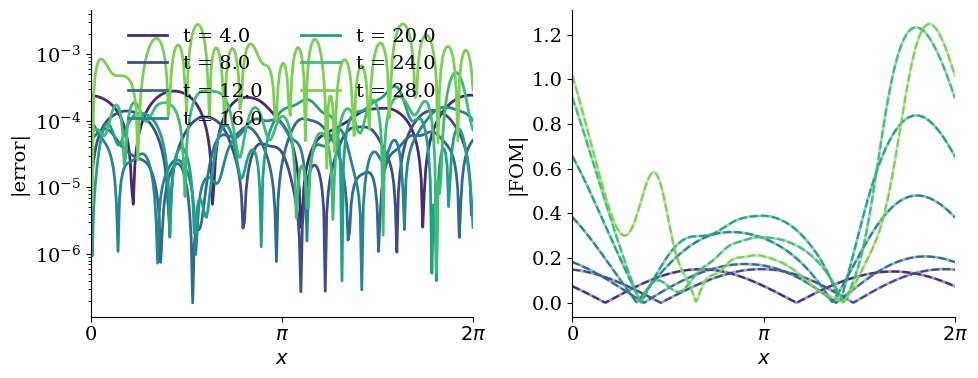

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
moment =1
skip = 40
# Choose a colormap
cmap = plt.get_cmap('viridis')
# Get an array of colors from the colormap
colors = cmap(np.linspace(0, 0.8, int(len(sol_midpoint_t)//skip +1))) 

for ii in np.arange(1, int(len(sol_midpoint_t)//skip + 1)):
    _ = ax[0].plot(x, np.abs(state_e2_midpoint[moment, :, ii*skip] - state_e2_FOM[moment, :, ii*skip]), c=colors[ii], linewidth=2, label="t = " + str(sol_midpoint_t[skip*ii]))
    _ = ax[1].plot(x, np.abs(state_e2_FOM[moment, :, ii*skip]), c=colors[ii], linewidth=2, alpha=0.5)
    _ = ax[1].plot(x, np.abs(state_e2_midpoint[moment, :, ii*skip]), color=colors[ii], ls="--")
ax[0].set_yscale("log")
#ax[1].set_yscale("log")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_xlim(0, 2*np.pi)
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_xlim(0, 2*np.pi)
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")
ax[0].set_ylabel("|error|")
ax[1].set_ylabel("|FOM|")
legend = ax[0].legend(ncols=2, fontsize=14, loc='upper center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

In [17]:
# save the electric field
np.save("../data/ROM/two_stream/sample_" + str(setup.u_e2) + "/sol_midpoint_E_" + str(setup.Nr)+ "_nu_" + str(setup.nu_e2) + ".npy", E_midpoint)

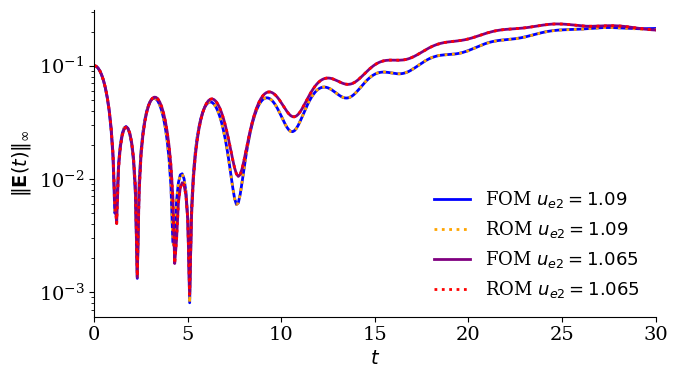

In [18]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(sol_midpoint_t, np.max(np.load("../data/FOM/two_stream/sample_1.09/sol_midpoint_E_" + str(setup.Nv)+ "_nu_" + str(setup.nu_e2) + ".npy"), axis=0)[:301], linewidth=2, color="blue", label=r"FOM $u_{e2} = 1.09$") 
ax.plot(sol_midpoint_t, np.max(np.load("../data/ROM/two_stream/sample_1.09/sol_midpoint_E_150_nu_" + str(setup.nu_e2) + ".npy"), axis=0)[:301], linewidth=2, color="orange", ls=":", label=r"ROM $u_{e2} = 1.09$") 

ax.plot(sol_midpoint_t, np.max(np.load("../data/FOM/two_stream/sample_1.065/sol_midpoint_E_" + str(setup.Nv)+ "_nu_" + str(setup.nu_e2) + ".npy"), axis=0)[:301], linewidth=2, color="purple", label=r"FOM $u_{e2} = 1.065$") 
ax.plot(sol_midpoint_t, np.max(E_midpoint, axis=0), ":", c="red", linewidth=2, label="ROM $u_{e2} = 1.065$") 


ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\|\mathbf{E}(t)\|_{\infty}$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
legend = ax.legend(ncols=1, fontsize=13, loc='lower right')
legend.get_frame().set_alpha(0)

plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/two_stream_electric_field_growth_rate.png", dpi=600)

In [19]:
# fig, ax = plt.subplots(figsize=(6, 4), dpi = 500)

# def animate(ii):
#     ii = int(10*ii)
#     distribution1 = np.zeros((len(x), len(v)))
#     distribution2 = np.zeros((len(x), len(v)))
#     for jj in range(setup.Nv):
#         distribution1 += np.outer(state_e1_midpoint[jj, :, ii], psi_ln_aw(xi=(v - setup.u_e1)/setup.alpha_e1, v=v, alpha_s=setup.alpha_e1, u_s=setup.u_e1, n=jj))
#         distribution2 += np.outer(state_e2_midpoint[jj, :, ii], psi_ln_aw(xi=(v - setup.u_e2)/setup.alpha_e2, v=v, alpha_s=setup.alpha_e2, u_s=setup.u_e2, n=jj))
#     pos = ax.pcolormesh(x, v, (distribution1 + distribution2).T, cmap="hot", vmin=0, vmax=0.4)
#     ax.set_yticks([-4, 0, 4, 8])
#     ax.set_ylabel("v")
#     #cbar = fig.colorbar(pos)
#     #cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", rotation=90)
#     #cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
#     ax.set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")
#     ax.set_xlabel("x")
#     ax.set_xticks([0, 10*np.pi/3, 20*np.pi/3])
#     ax.set_xticklabels([r"0", r"$10\pi/3$", r"$20\pi/3$"])
#     plt.tight_layout()
# ani = animation.FuncAnimation(fig, animate, frames=len(sol_midpoint_t[::10]))
# ani.save("../figs/FOM/bump_on_tail/bump_on_tail_FOM_ue2_" + str(setup.u_e2) + "_vid.gif", writer='pillow', dpi = "figure")
# plt.close()

In [20]:
#ani

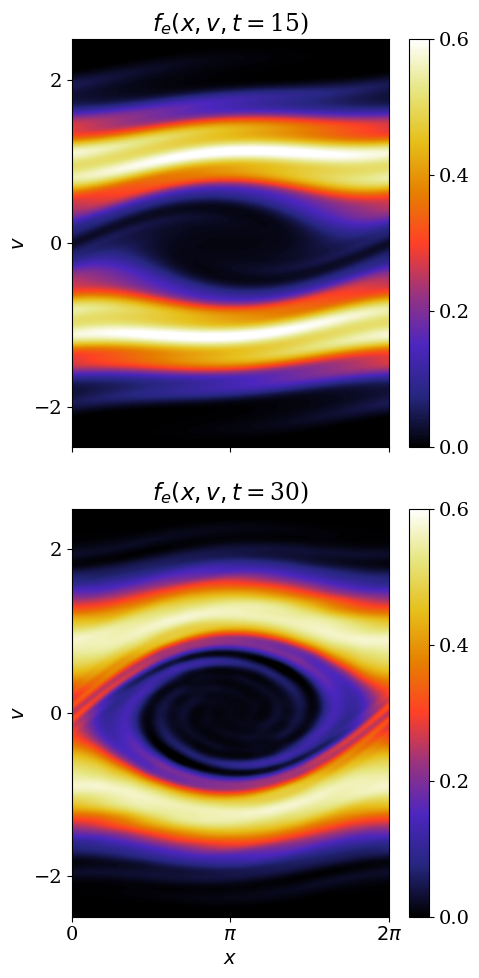

In [21]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=2, figsize=(5, 10), sharex=True)
for tt, ii in enumerate([151, 300]):
    ii = int(ii)
    distribution = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv):
        distribution += np.outer(state_e1_midpoint[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_e1, alpha_s=setup.alpha_e1, n=jj))
        distribution += np.outer(state_e2_midpoint[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_e2, alpha_s=setup.alpha_e2, n=jj))
    pos = ax[tt].pcolormesh(x, v, distribution.T, cmap="CMRmap", vmin=0, vmax=0.6, shading="gouraud")
    ax[tt].set_yticks([-2, 0, 2])
    ax[tt].set_ylabel("$v$")
    cbar = fig.colorbar(pos)
    cbar.ax.set_yticks([0, 0.2, 0.4, 0.6])
    ax[tt].set_title("$f_{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")

ax[tt].set_xlabel("$x$")
ax[tt].set_xticks([0, np.pi, 2*np.pi])
ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/sample_" + str(setup.u_e2) + "/two_stream_evolution_" + str(setup.u_e2) + "_Nr_" + str(setup.Nr) + "_M_" + str(setup.M) + ".png", dpi=200)

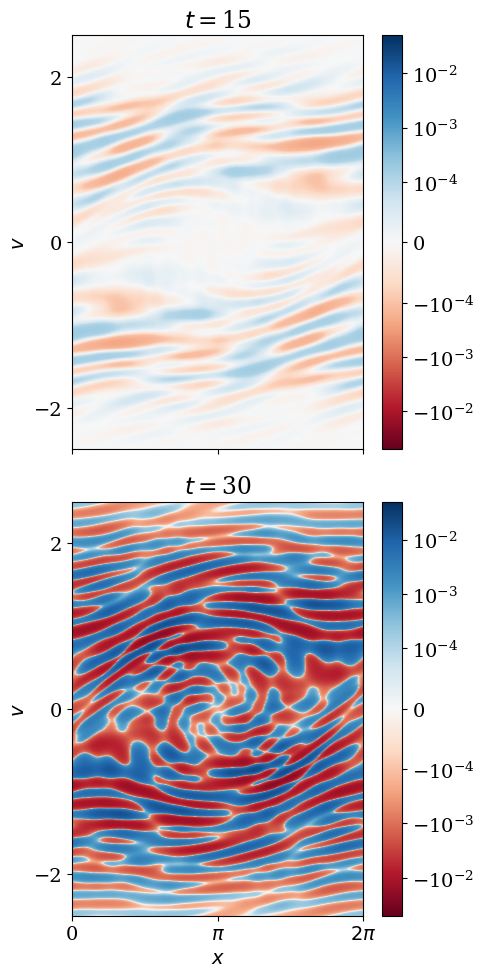

In [22]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=2, figsize=(5, 10), sharex=True)
for tt, ii in enumerate([151, 300]):
    ii = int(ii)
    distribution = np.zeros((len(x), len(v)))
    distribution_FOM = np.zeros((len(x), len(v)))
    
    for jj in range(setup.Nv):
        distribution += np.outer(state_e1_midpoint[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_e1, alpha_s=setup.alpha_e1, n=jj))
        distribution += np.outer(state_e2_midpoint[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_e2, alpha_s=setup.alpha_e2, n=jj))

        distribution_FOM += np.outer(state_e1_FOM[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_e1, alpha_s=setup.alpha_e1, n=jj))
        distribution_FOM += np.outer(state_e2_FOM[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_e2, alpha_s=setup.alpha_e2, n=jj))

    if tt == 0:
        pos = ax[tt].pcolormesh(x, v, (distribution_FOM - distribution).T, cmap="RdBu", shading="gouraud", norm=matplotlib.colors.SymLogNorm(vmin=-0.05, vmax=0.05, linthresh=1e-4))
    if tt == 1:
        pos = ax[tt].pcolormesh(x, v, (distribution_FOM - distribution).T, cmap="RdBu", shading="gouraud", norm=matplotlib.colors.SymLogNorm(vmin=-0.05, vmax=0.05, linthresh=1e-4))
    
    cbar = fig.colorbar(pos)
    ax[tt].set_yticks([-2, 0, 2])
    ax[tt].set_ylabel("$v$")
    ax[tt].set_title("$t=$" + str(int(sol_midpoint_t[ii])))

ax[tt].set_xlabel("$x$")
ax[tt].set_xticks([0, np.pi, 2*np.pi])
ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
plt.tight_layout()

plt.savefig("../figs/ROM/two_stream/sample_" + str(setup.u_e2) + "/two_stream_evolution_error_" + str(setup.u_e2) + "_Nr_" + str(setup.Nr) + "_M_" + str(setup.M) + ".png", dpi=200)

# conservation laws: mass, momentum, and energy

### mass conservation

In [28]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e1_midpoint[:, :-1, ii], alpha_s=setup.alpha_e1, dx=setup.dx)\
                        +total_mass(state=state_e2_midpoint[:, :-1, ii], alpha_s=setup.alpha_e2, dx=setup.dx)\
                        +total_mass(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx)

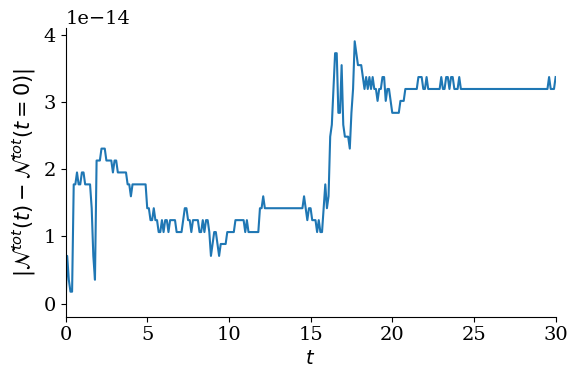

In [29]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### momentum conservation

In [30]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e1_midpoint[:, :-1, ii], alpha_s=setup.alpha_e1, dx=setup.dx,
                                           m_s=setup.m_e1, u_s=setup.u_e1)\
                            +total_momentum(state=state_e2_midpoint[:, :-1, ii], alpha_s=setup.alpha_e2, dx=setup.dx,
                                           m_s=setup.m_e2, u_s=setup.u_e2)\
                            +total_momentum(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx,
                                           m_s=setup.m_i, u_s=setup.u_i)

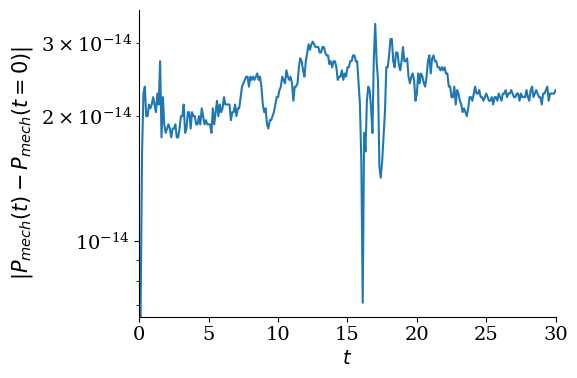

In [31]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
plt.tight_layout()

### energy conservation

In [32]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e1_midpoint[:, :-1, ii], alpha_s=setup.alpha_e1, dx=setup.dx, m_s=setup.m_e1, u_s=setup.u_e1)\
                            +total_energy_k(state=state_e2_midpoint[:, :-1, ii], alpha_s=setup.alpha_e2, dx=setup.dx, m_s=setup.m_e2, u_s=setup.u_e2)\
                            +total_energy_k(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

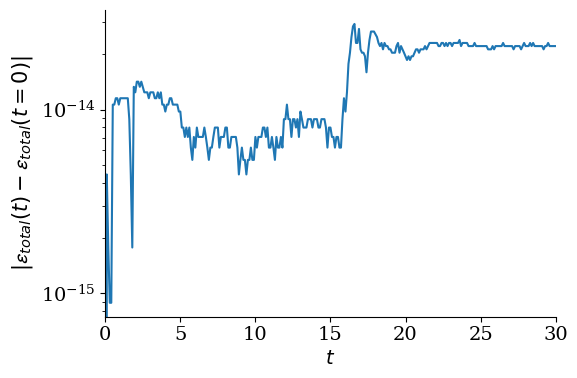

In [33]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

Text(0, 0.5, '$\\Delta E$')

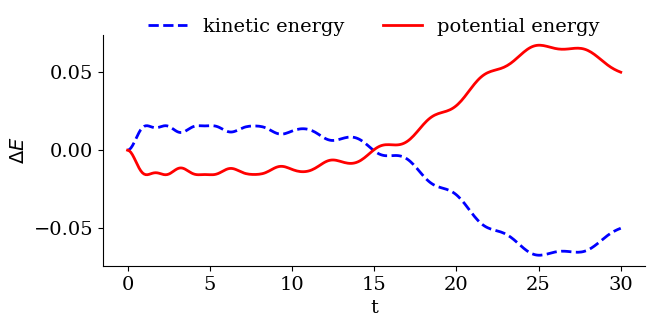

In [34]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
ax.set_ylabel(r"$\Delta E$")

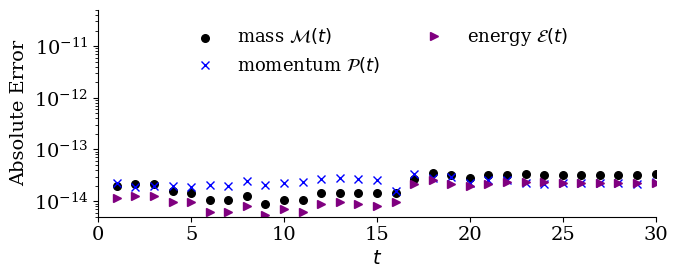

In [35]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::10], np.abs(mass_midpoint-mass_midpoint[0])[::10], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::10], np.abs(momentum_midpoint-momentum_midpoint[0])[::10], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::10], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::10], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, setup.T)
ax.set_yscale("log")
ax.set_ylim(5e-15, 5e-11)
legend = ax.legend(ncols=2, fontsize=13, loc='upper center')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/conservation_" + str(setup.Nv) + "_two_stream_ROM.png", bbox_inches='tight', dpi=300)

## Runtime, Error, and Efficiacy Comparison

In [38]:
Nr_sample = [120, 140, 150, 160]

runtime_M3 = np.zeros(len(Nr_sample))
runtime_M4 = np.zeros(len(Nr_sample))
runtime_M5 = np.zeros(len(Nr_sample))
runtime_M6 = np.zeros(len(Nr_sample))

for ii, Nr in enumerate(Nr_sample):
        runtime_M3[ii] = np.load("../data/ROM/two_stream/sample_" + str(setup.u_e2) + "/M3/sol_ROM_u_" + str(Nr) + "_nu_" + str(setup.nu_e1) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
    # runtime_M4[ii] = np.load("../data/ROM/two_stream/sample_" + str(setup.u_e2) + "/M4/sol_midpoint_u_" + str(Nr) + "_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
    # runtime_M5[ii] = np.load("../data/ROM/two_stream/sample_" + str(setup.u_e2) + "/M5/sol_midpoint_u_" + str(Nr) + "_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]
    # runtime_M6[ii] = np.load("../data/ROM/two_stream/sample_" + str(setup.u_e2) + "/M6/sol_midpoint_u_" + str(Nr) + "_nu_" + str(setup.nu) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[0]

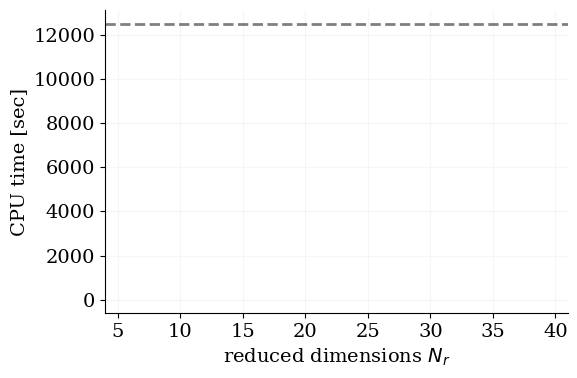

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.plasma(np.linspace(0,0.8,4))

ax.scatter(Nr_sample, runtime_M3, color=colors[0], marker="o")
ax.scatter(Nr_sample, runtime_M4, color=colors[1], marker="x")
ax.scatter(Nr_sample, runtime_M5, color=colors[2], marker=">")
ax.scatter(Nr_sample, runtime_M6, color=colors[3], marker="*")

runtime_fom =  np.load("../data/FOM/two_stream/sample_" + str(setup.u_e2) + "/sol_FOM_u_" + str(setup.Nv) + "_nu_" + str(setup.nu_e2) + "_runtime_" + str(setup.T0) + "_40.npy")
ax.axhline(runtime_fom[0]*3/4, color="black", alpha=0.5, linewidth=2, ls="--")

ax.set_ylabel("CPU time [sec]")
ax.set_xlabel("reduced dimensions $N_{r}$")
ax.set_xlim(4, 41)
#ax.set_ylim(1000, 1700)
ax.grid(alpha=0.1)
ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../figs/ROM/two_stream/two_stream_CPU_time_vs_Nr_" + str(setup.u_e2) + ".png", bbox_inches='tight', dpi=300)